# Configure environment


In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
#@title cuda Install
!echo CUDA AND NVIDIA INSTALLATION
!wget https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1604/x86_64/cuda-repo-ubuntu1604_8.0.61-1_amd64.deb;
!yes | dpkg -i cuda-repo-ubuntu1604_8.0.61-1_amd64.deb;
!apt-get update -qq;
!apt-get install cuda-8.0 -y;
!ln -sf /usr/local/cuda-8.0 /usr/local/cuda

import os
os.environ['PATH'] += ':/usr/local/cuda/bin'
os.environ['LD_LIBRARY_PATH'] += ':/usr/local/cuda/lib'

!apt-get install make gcc-5 g++-5 -y -qq;
!ln -s /usr/bin/gcc-5 /usr/local/cuda/bin/gcc;
!ln -s /usr/bin/g++-5 /usr/local/cuda/bin/g++;
!pip install git+git://github.com/andreinechaev/nvcc4jupyter.git
%load_ext nvcc_plugin

In [2]:
!pip install Pillow

In [0]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

%matplotlib inline

In [6]:
%%shell 
git clone https://github.com/fstovarr/ParallelComputingLabs.git
cd ParallelComputingLabs
git checkout develop

Cloning into 'ParallelComputingLabs'...
remote: Enumerating objects: 339, done.
remote: Counting objects: 100% (339/339), done.
remote: Compressing objects: 100% (266/266), done.
remote: Total 1490 (delta 98), reused 279 (delta 60), pack-reused 1151
Receiving objects: 100% (1490/1490), 212.17 MiB | 40.76 MiB/s, done.
Resolving deltas: 100% (539/539), done.
Branch 'develop' set up to track remote branch 'develop' from 'origin'.
Switched to a new branch 'develop'


In [7]:
%cd ParallelComputingLabs/BlurGPU/BlurEffectCUDA/
%mkdir src
%ls src

/content/ParallelComputingLabs/BlurGPU/BlurEffectCUDA
mkdir: cannot create directory ‘src’: File exists
blur-effect.cu


In [0]:
%cp -r /usr/local/cuda-8.0/samples/common/ ./lib/common

#Makefile


In [9]:
%%writefile Makefile
################################################################################
#
# Copyright 1993-2015 NVIDIA Corporation.  All rights reserved.
#
# NOTICE TO USER:
#
# This source code is subject to NVIDIA ownership rights under U.S. and
# international Copyright laws.
#
# NVIDIA MAKES NO REPRESENTATION ABOUT THE SUITABILITY OF THIS SOURCE
# CODE FOR ANY PURPOSE.  IT IS PROVIDED "AS IS" WITHOUT EXPRESS OR
# IMPLIED WARRANTY OF ANY KIND.  NVIDIA DISCLAIMS ALL WARRANTIES WITH
# REGARD TO THIS SOURCE CODE, INCLUDING ALL IMPLIED WARRANTIES OF
# MERCHANTABILITY, NONINFRINGEMENT, AND FITNESS FOR A PARTICULAR PURPOSE.
# IN NO EVENT SHALL NVIDIA BE LIABLE FOR ANY SPECIAL, INDIRECT, INCIDENTAL,
# OR CONSEQUENTIAL DAMAGES, OR ANY DAMAGES WHATSOEVER RESULTING FROM LOSS
# OF USE, DATA OR PROFITS, WHETHER IN AN ACTION OF CONTRACT, NEGLIGENCE
# OR OTHER TORTIOUS ACTION, ARISING OUT OF OR IN CONNECTION WITH THE USE
# OR PERFORMANCE OF THIS SOURCE CODE.
#
# U.S. Government End Users.  This source code is a "commercial item" as
# that term is defined at 48 C.F.R. 2.101 (OCT 1995), consisting  of
# "commercial computer software" and "commercial computer software
# documentation" as such terms are used in 48 C.F.R. 12.212 (SEPT 1995)
# and is provided to the U.S. Government only as a commercial end item.
# Consistent with 48 C.F.R.12.212 and 48 C.F.R. 227.7202-1 through
# 227.7202-4 (JUNE 1995), all U.S. Government End Users acquire the
# source code with only those rights set forth herein.
#
################################################################################
#
# Makefile project only supported on Mac OS X and Linux Platforms)
#
################################################################################

# Location of the CUDA Toolkit
CUDA_PATH ?= /usr/local/cuda-8.0

##############################
# start deprecated interface #
##############################
ifeq ($(x86_64),1)
    $(info WARNING - x86_64 variable has been deprecated)
    $(info WARNING - please use TARGET_ARCH=x86_64 instead)
    TARGET_ARCH ?= x86_64
endif
ifeq ($(ARMv7),1)
    $(info WARNING - ARMv7 variable has been deprecated)
    $(info WARNING - please use TARGET_ARCH=armv7l instead)
    TARGET_ARCH ?= armv7l
endif
ifeq ($(aarch64),1)
    $(info WARNING - aarch64 variable has been deprecated)
    $(info WARNING - please use TARGET_ARCH=aarch64 instead)
    TARGET_ARCH ?= aarch64
endif
ifeq ($(ppc64le),1)
    $(info WARNING - ppc64le variable has been deprecated)
    $(info WARNING - please use TARGET_ARCH=ppc64le instead)
    TARGET_ARCH ?= ppc64le
endif
ifneq ($(GCC),)
    $(info WARNING - GCC variable has been deprecated)
    $(info WARNING - please use HOST_COMPILER=$(GCC) instead)
    HOST_COMPILER ?= $(GCC)
endif
ifneq ($(abi),)
    $(error ERROR - abi variable has been removed)
endif
############################
# end deprecated interface #
############################

# architecture
HOST_ARCH   := $(shell uname -m)
TARGET_ARCH ?= $(HOST_ARCH)
ifneq (,$(filter $(TARGET_ARCH),x86_64 aarch64 ppc64le armv7l))
    ifneq ($(TARGET_ARCH),$(HOST_ARCH))
        ifneq (,$(filter $(TARGET_ARCH),x86_64 aarch64 ppc64le))
            TARGET_SIZE := 64
        else ifneq (,$(filter $(TARGET_ARCH),armv7l))
            TARGET_SIZE := 32
        endif
    else
        TARGET_SIZE := $(shell getconf LONG_BIT)
    endif
else
    $(error ERROR - unsupported value $(TARGET_ARCH) for TARGET_ARCH!)
endif
ifneq ($(TARGET_ARCH),$(HOST_ARCH))
    ifeq (,$(filter $(HOST_ARCH)-$(TARGET_ARCH),aarch64-armv7l x86_64-armv7l x86_64-aarch64 x86_64-ppc64le))
        $(error ERROR - cross compiling from $(HOST_ARCH) to $(TARGET_ARCH) is not supported!)
    endif
endif

# When on native aarch64 system with userspace of 32-bit, change TARGET_ARCH to armv7l
ifeq ($(HOST_ARCH)-$(TARGET_ARCH)-$(TARGET_SIZE),aarch64-aarch64-32)
    TARGET_ARCH = armv7l
endif

# operating system
HOST_OS   := $(shell uname -s 2>/dev/null | tr "[:upper:]" "[:lower:]")
TARGET_OS ?= $(HOST_OS)
ifeq (,$(filter $(TARGET_OS),linux darwin qnx android))
    $(error ERROR - unsupported value $(TARGET_OS) for TARGET_OS!)
endif

# host compiler
ifeq ($(TARGET_OS),darwin)
    ifeq ($(shell expr `xcodebuild -version | grep -i xcode | awk '{print $$2}' | cut -d'.' -f1` \>= 5),1)
        HOST_COMPILER ?= clang++
    endif
else ifneq ($(TARGET_ARCH),$(HOST_ARCH))
    ifeq ($(HOST_ARCH)-$(TARGET_ARCH),x86_64-armv7l)
        ifeq ($(TARGET_OS),linux)
            HOST_COMPILER ?= arm-linux-gnueabihf-g++
        else ifeq ($(TARGET_OS),qnx)
            ifeq ($(QNX_HOST),)
                $(error ERROR - QNX_HOST must be passed to the QNX host toolchain)
            endif
            ifeq ($(QNX_TARGET),)
                $(error ERROR - QNX_TARGET must be passed to the QNX target toolchain)
            endif
            export QNX_HOST
            export QNX_TARGET
            HOST_COMPILER ?= $(QNX_HOST)/usr/bin/arm-unknown-nto-qnx6.6.0eabi-g++
        else ifeq ($(TARGET_OS),android)
            HOST_COMPILER ?= arm-linux-androideabi-g++
        endif
    else ifeq ($(TARGET_ARCH),aarch64)
        ifeq ($(TARGET_OS), linux)
            HOST_COMPILER ?= aarch64-linux-gnu-g++
        else ifeq ($(TARGET_OS),qnx)
            ifeq ($(QNX_HOST),)
                $(error ERROR - QNX_HOST must be passed to the QNX host toolchain)
            endif
            ifeq ($(QNX_TARGET),)
                $(error ERROR - QNX_TARGET must be passed to the QNX target toolchain)
            endif
            export QNX_HOST
            export QNX_TARGET
            HOST_COMPILER ?= $(QNX_HOST)/usr/bin/aarch64-unknown-nto-qnx7.0.0-g++
        else ifeq ($(TARGET_OS), android)
            HOST_COMPILER ?= aarch64-linux-android-g++
        endif
    else ifeq ($(TARGET_ARCH),ppc64le)
        HOST_COMPILER ?= powerpc64le-linux-gnu-g++
    endif
endif
HOST_COMPILER ?= g++
NVCC          := $(CUDA_PATH)/bin/nvcc -ccbin $(HOST_COMPILER)

# internal flags
NVCCFLAGS   := -m${TARGET_SIZE}
CCFLAGS     :=
LDFLAGS     :=

# build flags
ifeq ($(TARGET_OS),darwin)
    LDFLAGS += -rpath $(CUDA_PATH)/lib
    CCFLAGS += -arch $(HOST_ARCH)
else ifeq ($(HOST_ARCH)-$(TARGET_ARCH)-$(TARGET_OS),x86_64-armv7l-linux)
    LDFLAGS += --dynamic-linker=/lib/ld-linux-armhf.so.3
    CCFLAGS += -mfloat-abi=hard
else ifeq ($(TARGET_OS),android)
    LDFLAGS += -pie
    CCFLAGS += -fpie -fpic -fexceptions
endif

ifneq ($(TARGET_ARCH),$(HOST_ARCH))
    ifeq ($(TARGET_ARCH)-$(TARGET_OS),armv7l-linux)
        ifneq ($(TARGET_FS),)
            GCCVERSIONLTEQ46 := $(shell expr `$(HOST_COMPILER) -dumpversion` \<= 4.6)
            ifeq ($(GCCVERSIONLTEQ46),1)
                CCFLAGS += --sysroot=$(TARGET_FS)
            endif
            LDFLAGS += --sysroot=$(TARGET_FS)
            LDFLAGS += -rpath-link=$(TARGET_FS)/lib
            LDFLAGS += -rpath-link=$(TARGET_FS)/usr/lib
            LDFLAGS += -rpath-link=$(TARGET_FS)/usr/lib/arm-linux-gnueabihf
        endif
    endif
endif

# Debug build flags
ifeq ($(dbg),1)
      NVCCFLAGS += -g -G
      BUILD_TYPE := debug
else
      BUILD_TYPE := release
endif

ALL_CCFLAGS :=
ALL_CCFLAGS += $(NVCCFLAGS)
ALL_CCFLAGS += $(EXTRA_NVCCFLAGS)
ALL_CCFLAGS += $(addprefix -Xcompiler ,$(CCFLAGS))
ALL_CCFLAGS += $(addprefix -Xcompiler ,$(EXTRA_CCFLAGS))

SAMPLE_ENABLED := 1

ALL_LDFLAGS :=
ALL_LDFLAGS += $(ALL_CCFLAGS)
ALL_LDFLAGS += $(addprefix -Xlinker ,$(LDFLAGS))
ALL_LDFLAGS += $(addprefix -Xlinker ,$(EXTRA_LDFLAGS))

# Common includes and paths for CUDA
INCLUDES  := -I./lib/common/inc
LIBRARIES :=

################################################################################

# Gencode arguments
SMS ?= 20 30 35 37 50 52 60

ifeq ($(SMS),)
$(info >>> WARNING - no SM architectures have been specified - waiving sample <<<)
SAMPLE_ENABLED := 0
endif

ifeq ($(GENCODE_FLAGS),)
# Generate SASS code for each SM architecture listed in $(SMS)
$(foreach sm,$(SMS),$(eval GENCODE_FLAGS += -gencode arch=compute_$(sm),code=sm_$(sm)))

# Generate PTX code from the highest SM architecture in $(SMS) to guarantee forward-compatibility
HIGHEST_SM := $(lastword $(sort $(SMS)))
ifneq ($(HIGHEST_SM),)
GENCODE_FLAGS += -gencode arch=compute_$(HIGHEST_SM),code=compute_$(HIGHEST_SM)
endif
endif

ifeq ($(SAMPLE_ENABLED),0)
EXEC ?= @echo "[@]"
endif

################################################################################

# Target rules
all: prepare build clean

build: blur-effect

prepare:
	-@mkdir bin/

check.deps:
ifeq ($(SAMPLE_ENABLED),0)
	@echo "Sample will be waived due to the above missing dependencies"
else
	@echo "Sample is ready - all dependencies have been met"
endif

blur-effect.o:src/blur-effect.cu
	$(EXEC) $(NVCC) $(INCLUDES) $(ALL_CCFLAGS) $(GENCODE_FLAGS) -o $@ -c $<

blur-effect: blur-effect.o
	$(EXEC) $(NVCC) $(ALL_LDFLAGS) $(GENCODE_FLAGS) -o $@ $+ $(LIBRARIES)
	$(EXEC) mv $@ ./bin/

run: build
	$(EXEC) ./blur-effect

clean:
	rm -f blur-effect.o

clobber: clean

Overwriting Makefile


#Blur effect CUDA

In [24]:
%%writefile src/blur-effect.cu 

#include <stdio.h>
#include <math.h>
#include <stdlib.h>
#define STB_IMAGE_IMPLEMENTATION
#include "../lib/stb/stb_image.h"
#define STB_IMAGE_WRITE_IMPLEMENTATION
#include "../lib/stb/stb_image_write.h"
#include <sys/time.h>
#include <cuda_runtime.h>
#include <helper_cuda.h>

#define SIGMA 15
#define MIN(x, y) ((x < y) ? x : y)
#define CHECK(call)                                                            \
{                                                                              \
    const cudaError_t error = call;                                            \
    if (error != cudaSuccess)                                                  \
    {                                                                          \
        fprintf(stderr, "Error: %s:%d, ", __FILE__, __LINE__);                 \
        fprintf(stderr, "code: %d, reason: %s\n", error,                       \
                cudaGetErrorString(error));                                    \
    }                                                                          \
}

#if !defined(__CUDA_ARCH__) || __CUDA_ARCH__ >= 600
#else
__device__ double atomicAdd(double* a, double b) { return b; }
#endif

// http://pages.stat.wisc.edu/~mchung/teaching/MIA/reading/diffusion.gaussian.kernel.pdf.pdf
__global__ void generateGaussianKernel(double *k, double *accumulation, int size, double sigma) {
    int idx = blockDim.x * blockIdx.x + threadIdx.x;
    int x = idx % size, y = idx / size;
    int i = 0;

    if(idx < size * size) {
        k[idx] = (double)(exp(-(x * x + y * y) / (2.0 * sigma * sigma)) / (2.0 * sigma * sigma * M_PI));
        atomicAdd(accumulation, k[idx]);
    }

    __syncthreads();
    
    if(idx == 0) {
      for (i = 0; i < (size * size); i++)
        k[i] /= *accumulation;
    }    
}

__device__ void calculatePixel(unsigned char *in, unsigned char *out, long int i, int w, int h, int channels, double* kernel, int kernel_size) {
    int kernel_pad = kernel_size / 2, px;
    double v = 0.0, total = 0.0;

    for (int l = 0; l < channels; l++) {
        total = 0.0;
        for (int m = -kernel_pad; m <= kernel_pad; m++)
            for (int n = -kernel_pad; n <= kernel_pad; n++) {
                v = kernel[(m  + kernel_pad) * kernel_size + (n + kernel_pad)];
                px = in[(i + l + m * channels + n * channels * w) % (w * h * channels)];
                total += v * px;
            }
        out[i + l] = total;
    }
}

__global__ void applyFilter(unsigned char *in, unsigned char *out, double *kernel, int w, int h, int c, int kernel_size, int chunk_size, int total_threads) {
    int kernel_pad = kernel_size / 2;
    size_t size = w * h * c;
    long int start = (blockDim.x * blockIdx.x + threadIdx.x) * chunk_size;
    long int end = (start + chunk_size) < (w * h) ? (start + chunk_size) : (w * h);

    if(start < w * h)
      for(int idx = start * c; idx < end * c; idx += c)
          if(idx >= kernel_pad * w * c && // Top
              idx < (size - kernel_pad * w * c) && // Bottom
              idx % (w * c) >= kernel_pad * c && // Left
              idx % (w * c) < (w * c - kernel_pad * c)) // Right
              calculatePixel(in, out, idx, w, h, c, kernel, kernel_size);
          else 
              for (int j = 0; j < c; j++)
                out[idx + j] = 0;
}

int main(int argc, char *argv[]) {
    if(argc < 5) {
        printf("Wrong arguments!\n");
        return -1;
    }

    struct timeval after, before, result;
    gettimeofday(&before, NULL);

    char *DIR_IMG_INPUT, *DIR_IMG_OUTPUT;
    int KERNEL_SIZE, verbose, THREADS = -1, BLOCKS = -1;
    double sigma;

    DIR_IMG_INPUT = argv[1];
    DIR_IMG_OUTPUT = argv[2];

    KERNEL_SIZE = 3;
    sscanf(argv[3], "%d", &KERNEL_SIZE);
    if(KERNEL_SIZE % 2 == 0) {
        printf("Kernel size must be odd");
        return -1;
    }

    if(argv[4] != NULL)
        sscanf(argv[4], "%d", &THREADS);

    if(argv[5] != NULL)
        sscanf(argv[5], "%d", &BLOCKS);

    int _auto = 0;
    if(THREADS == -1 || BLOCKS == -1)
        _auto = 1;

    sigma = SIGMA;
    if(argv[6] != 0) sscanf(argv[6], "%lf", &sigma);

    if(argv[7] != NULL) {
        sscanf(argv[7], "%d", &verbose);
        if(verbose != 1)
            verbose = 0;
    }

    int deviceCount = 0;
    CHECK(cudaGetDeviceCount(&deviceCount));

    if (deviceCount == 0) {
        printf("There are no available device(s) that support CUDA\n");
        return -1;
    }

    if(verbose) printf("Detected %d CUDA Capable device(s)\n", deviceCount);

    cudaSetDevice(0);
    cudaDeviceProp deviceProp;
    cudaGetDeviceProperties(&deviceProp, 0);

    int coresPerMP = _ConvertSMVer2Cores(deviceProp.major, deviceProp.minor);
    int multiProcessors = deviceProp.multiProcessorCount;

    if(verbose)
      printf("%d Multiprocessors, %d CUDA Cores/MP | %d CUDA Cores\nMaximum number of threads per block: %d\n",
             deviceProp.multiProcessorCount,
             _ConvertSMVer2Cores(deviceProp.major, deviceProp.minor),
             _ConvertSMVer2Cores(deviceProp.major, deviceProp.minor) * deviceProp.multiProcessorCount,
             deviceProp.maxThreadsPerBlock);
    
    int blocksPerGrid, threadsPerBlock;
    int kernel_cells = KERNEL_SIZE * KERNEL_SIZE;

    double h_kernel[KERNEL_SIZE][KERNEL_SIZE];
    double *d_kernel;

    CHECK(cudaMalloc((void **) &d_kernel, kernel_cells * sizeof(double)));

    double *d_sum;
    CHECK(cudaMalloc((void **) &d_sum, sizeof(double)));

    threadsPerBlock = MIN(coresPerMP, kernel_cells);
    blocksPerGrid = floor(kernel_cells / threadsPerBlock) + 1;

    generateGaussianKernel<<<blocksPerGrid, threadsPerBlock>>>((double *) d_kernel, d_sum, KERNEL_SIZE, sigma);

    CHECK(cudaMemcpy(h_kernel, d_kernel, kernel_cells * sizeof(double), cudaMemcpyDeviceToHost));

    if(verbose)
      printf("Kernel computed with %d threads in %d blocks\n.", threadsPerBlock, blocksPerGrid);

    cudaFree(d_sum);

    unsigned char *h_data;
    int width, height, channels;
    h_data = stbi_load(DIR_IMG_INPUT, &width, &height, &channels, STBI_default);

    if (h_data != NULL) {
        if(verbose) printf("\nImage dimensions: (%dpx, %dpx) and %d channels.\n", width, height, channels);

        size_t image_size = width * height * channels; 

        unsigned char *h_output_image, *d_data, *d_output_image;
        CHECK(cudaMalloc((void **) &d_output_image, image_size * sizeof(unsigned char)));
        CHECK(cudaMalloc((void **) &d_data, image_size * sizeof(unsigned char)));
        CHECK(cudaMemcpy(d_data, h_data, image_size * sizeof(unsigned char), cudaMemcpyHostToDevice));
        
        h_output_image = (unsigned char*) malloc(image_size * sizeof(unsigned char));
        if(h_output_image == NULL) {
            printf("Error trying to allocate memory space");
            free(h_output_image);
            stbi_image_free(h_data);
            return -1;
        }

        if(_auto == 1) {
            threadsPerBlock = MIN(coresPerMP * 2, width * height);
            blocksPerGrid = floor(width * height / threadsPerBlock) + 1;
        } else {
            threadsPerBlock = THREADS;
            blocksPerGrid = BLOCKS;
        }

        int total_threads = (threadsPerBlock * blocksPerGrid);
        int chunk_size = MAX(1, floor((width * height) / total_threads));

        applyFilter<<<blocksPerGrid, threadsPerBlock>>>(d_data, d_output_image, d_kernel, width, height, channels, KERNEL_SIZE, chunk_size, total_threads);

        CHECK(cudaMemcpy(h_output_image, d_output_image, image_size * sizeof(unsigned char), cudaMemcpyDeviceToHost));

        if(verbose)
          printf("Filter applied in %s mode with %d threads in %d blocks\n.", _auto ? "auto" : "manual", threadsPerBlock, blocksPerGrid);

        CHECK(cudaFree(d_kernel));
        CHECK(cudaFree(d_output_image));
        CHECK(cudaFree(d_data));

        if (!stbi_write_png(DIR_IMG_OUTPUT, width, height, channels, h_output_image, width * channels))
            printf("Image cannot be created");
        else
            if(verbose) printf("Image created");

        free(h_output_image);
        free(h_data);
    } else {
        printf("Error loading the image");
    }

    gettimeofday(&after, NULL);
    timersub(&after, &before, &result);

    if(verbose) printf("\nTime elapsed: %ld.%06ld\n", (long int) result.tv_sec, (long int) result.tv_usec);
    else
        printf("%ld.%06ld\n", (long int)result.tv_sec, (long int)result.tv_usec);

    stbi_image_free(h_data);
}

Overwriting src/blur-effect.cu


# Run code

In [0]:
#@title make
!make

Detected 1 CUDA Capable device(s)
56 Multiprocessors, 64 CUDA Cores/MP | 3584 CUDA Cores
Maximum number of threads per block: 1024
Kernel computed with 64 threads in 71 blocks
.
Image dimensions: (1280px, 720px) and 3 channels.
Filter applied in auto mode with 128 threads in 7201 blocks
.Image created
Time elapsed: 0.717977


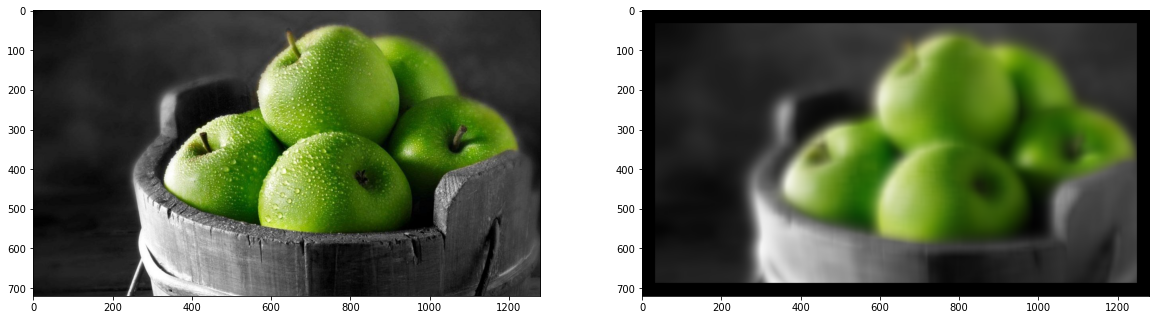

In [26]:
#@title Blur effect
import os
input_file = "./img/test720.jpg" #@param {type:"string"}
output_file = "./test720.png" #@param {type:"string"}
kernel_size = 67 #@param {type:"slider", min:3, max:1001, step:2}
threads_per_block =  -1#@param {type:"integer",min:-1,default:-1}
blocks_per_grid =   -1#@param {type:"integer",default:-1}
sigma = 20#@param {type:"number", min:0}
verbose = True #@param {type:"boolean"}

#@markdown For automatic configuration of threads and blocks set `threads_per_block` and `threads_per_block` with -1

os.environ["KERNEL_SIZE"] = str(kernel_size)
os.environ["SIGMA"] = str(sigma)
os.environ["VERBOSE"] = "1" if verbose else "0"
os.environ["INPUT_FILE"] = input_file
os.environ["OUTPUT_FILE"] = output_file
os.environ["NUM_THREADS"] = str(threads_per_block)
os.environ["NUM_BLOCKS"] = str(blocks_per_grid)

!./bin/blur-effect $INPUT_FILE $OUTPUT_FILE $KERNEL_SIZE $NUM_THREADS $NUM_BLOCKS $SIGMA $VERBOSE

fig = plt.figure(figsize=(20, 20))

pil_im = Image.open(os.environ["INPUT_FILE"], 'r')
fig.add_subplot(1, 2, 1)
plt.imshow(np.asarray(pil_im));

pil_im = Image.open(os.environ["OUTPUT_FILE"], 'r')
fig.add_subplot(1, 2, 2)
plt.imshow(np.asarray(pil_im));

plt.show()

# TestBench


## Sequential


In [0]:
%%shell
cd /content/ParallelComputingLabs/BlurCPU/Blur/
make

In [0]:
!mkdir -p '/content/drive/My Drive/results/sequential/imgs'
!mkdir -p /content/img/sequential

import os
iterations = 3

for image in ['test720.jpg']:
  f = open("/content/drive/My Drive/results/sequential/{0}a.out".format(image), "a+")
  os.environ["OUT_NAME"] = "/content/drive/My Drive/results/sequential/{0}b.out".format(image)
  for kernel in [3, 7, 13, 17]:
    if(kernel % 2 == 0):
      kernel += 1

    # for blocks in range(1, 25, 3):
    # for threads in [1, 2, 4, 8, 16]:
    for i in range(iterations):
      os.environ["KERNEL_SIZE"] = str(kernel)
      os.environ["INPUT_FILE"] = "/content/ParallelComputingLabs/BlurCPU/Blur/img/{0}".format(image)
      os.environ["OUTPUT_FILE"] = "/content/img/sequential/{0}".format(image)
      # os.environ["NUM_THREADS"] = str(threads)
      # os.environ["NUM_BLOCKS"] = str(blocks)

      print("[{1}] Blocks: {0}".format(kernel, image))
      
      f.write("{0}\n".format(kernel))

      !/content/ParallelComputingLabs/BlurCPU/Blur/bin/./blur_effect_sequential $INPUT_FILE $OUTPUT_FILE $KERNEL_SIZE 20 0 >> "${OUT_NAME}"
  f.close()

## CUDA

In [0]:
!mkdir -p '/content/drive/My Drive/results/CUDA/imgs'
!mkdir -p /content/img/CUDA

import os
iterations = 3

for image in ['test720.jpg', 'test1080.jpg', 'test4k.jpg']:
  f = open("/content/drive/My Drive/results/CUDA/{0}a.out".format(image), "a+")
  os.environ["OUT_NAME"] = "/content/drive/My Drive/results/CUDA/{0}b.out".format(image)
  for kernel in range(3, 50, 14):
    if(kernel % 2 == 0):
      kernel += 1

    for blocks in range(1, 25, 3):
      # for threads in [2, 4, 8, 16, 32]:
      for i in range(iterations):
        os.environ["KERNEL_SIZE"] = str(kernel)
        os.environ["INPUT_FILE"] = "/content/ParallelComputingLabs/BlurCPU/Blur/img/{0}".format(image)
        os.environ["OUTPUT_FILE"] = "/content/img/CUDA/{0}".format(image)
        os.environ["NUM_THREADS"] = str(64)
        os.environ["NUM_BLOCKS"] = str(blocks)

        print("[{3}] KERNEL: {4}, Blocks: {0}, threads: {1}, total: {2}".format(blocks, 112, blocks * 112, image, kernel))
        
        f.write("{0}\t{1}\t{2}\n".format(blocks, 112, kernel))

        !/content/ParallelComputingLabs/BlurGPU/BlurEffectCUDA/bin/./blur-effect $INPUT_FILE $OUTPUT_FILE $KERNEL_SIZE $NUM_THREADS $NUM_BLOCKS 20 0 >> "${OUT_NAME}"
  f.close()